# Introduction: This is a MDCCA test.

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json

import sys
sys.path.append('../0 utils/')
from tool import *

from sklearn.model_selection import train_test_split


data_root = '../../MyData/'

## Load data

In [2]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LONG_DESC_embeddings  \
0  [0.06089901179075241, -0.07059630751609802, -0...   
1  [-0.021961161866784096, 0.02030270546674

,cik,tic,Year,item1_embeddings,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...","[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....","[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...","[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...","[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...","[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [3]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




## Obtain tensors and prepare data

In [45]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year']

exp_df = convert_to_array(total_embedding, info_list, target_list, 1536, True)
print(type(exp_df))
print(exp_df.shape)


item1_np = np.vstack(exp_df['item1_embeddings'].values)
sp_long_np = np.vstack(exp_df['SP_LONG_DESC_embeddings'].values)
orbis_np = np.vstack(exp_df['ORBIS_OVERVIEW_embeddings'].values)
# combined_array = np.concatenate([item1, sp_long, orbis], axis=1)

<class 'pandas.core.frame.DataFrame'>
(926, 6)


In [46]:
from sklearn.decomposition import PCA
'''
If the dimension is too large (more than 128), the deep neural network get too complex,
So it leads to severe overfitting.
'''
pca = PCA(n_components=64)
item1_np = pca.fit_transform(item1_np)
sp_long_np = pca.fit_transform(sp_long_np)
orbis_np = pca.fit_transform(orbis_np)

print(item1_np.shape)
item1_np

(926, 64)


array([[-0.00913671,  0.33057058, -0.08595407, ..., -0.02788438,
         0.03160677,  0.02828892],
       [-0.18024387,  0.23354474, -0.0066326 , ...,  0.03303214,
         0.03994126, -0.0290035 ],
       [ 0.08223159, -0.11439043,  0.22086728, ...,  0.06125869,
         0.01908118, -0.0238059 ],
       ...,
       [-0.13244995,  0.1267212 , -0.06033578, ...,  0.03811198,
         0.04705617,  0.03934089],
       [ 0.09807554, -0.08446089,  0.08403672, ...,  0.03799082,
        -0.04436886,  0.00727111],
       [ 0.1400567 ,  0.00146885,  0.0974325 , ..., -0.03764336,
        -0.07060943,  0.02311001]])

In [47]:
train_idx, test_idx = train_test_split(np.arange(len(item1_np)), test_size=0.2, random_state=42)
# val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Split data using the computed indices
item1_train, item1_test = item1_np[train_idx], item1_np[test_idx]
sp_long_train, sp_long_test = sp_long_np[train_idx], sp_long_np[test_idx]
orbis_train, orbis_test = orbis_np[train_idx], orbis_np[test_idx]


# Experiment 1: Utilize MCCA

In [48]:
from mvlearn.embed import MCCA

mcca = MCCA(n_components=16)
mcca.fit([item1_train, sp_long_train, orbis_train])
Xs_scores = mcca.transform([item1_test, sp_long_test, orbis_test])

In [49]:
# Compute correlation for each row
def row_correlation(x, y):
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)
    
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    numerator = (x_centered * y_centered).sum(dim=1)
    denominator = torch.sqrt((x_centered ** 2).sum(dim=1) * (y_centered ** 2).sum(dim=1))
    
    correlation = numerator / denominator
    return correlation

correlations = row_correlation(torch.tensor(Xs_scores[0]), torch.tensor(Xs_scores[1]))

# Compute the average correlation
average_correlation = correlations.mean()

print("Average correlation:", average_correlation.item())

Average correlation: 0.9309735016893492


## Taking average

In [50]:
Xs_scores = mcca.transform([item1_np, sp_long_np, orbis_np])
mean_array = np.mean(Xs_scores, axis=0)

print(mean_array.shape)
mean_array

(926, 16)


array([[-2.97518254e-02, -5.54866571e-03,  4.04199732e-02, ...,
         1.33086655e-02,  1.74819358e-02,  1.22033349e-02],
       [-7.98297191e-03, -2.84815954e-02,  4.13187234e-02, ...,
        -3.40190547e-02,  1.11452868e-03,  7.82970175e-03],
       [ 5.29596136e-02,  2.59719944e-02,  4.34551071e-02, ...,
         3.09880632e-02, -2.70692479e-02, -3.47690264e-03],
       ...,
       [-1.14253908e-02, -2.93020692e-02,  1.02876324e-02, ...,
         2.84903100e-06,  1.10706097e-03,  2.09551434e-02],
       [ 1.98281401e-02,  2.53647832e-02, -6.17876064e-03, ...,
         1.17519654e-02,  3.26966519e-02, -2.07681878e-02],
       [-5.18700537e-03,  1.29387239e-02, -5.08016038e-03, ...,
        -2.06316475e-02,  6.15482549e-02, -3.54914177e-02]])

## clustering and evaluation

In [51]:
exp1_df = exp_df[['cik', 'tic', 'Year']].copy()
exp1_df['cluster_10'] = cluster(mean_array, 10)
exp1_df['cluster_100'] = cluster(mean_array, 100)
exp1_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.0002641325301785009
Normalized Within-Cluster Sum of Squares (WCSS): 9.109289803585109e-05


,cik,tic,Year,cluster_10,cluster_100
1,352541,LNT,2021,6,53
2,1704715,AMR,2021,6,21
3,1575515,SFM,2021,0,0
4,1125376,ENSG,2021,9,80
5,1674335,JELD,2021,3,35
...,...,...,...,...,...
1190,1653653,RRR,2021,1,43
1191,1627223,CC,2021,7,54
1192,1021860,NOV,2021,6,52
1193,1744489,DIS,2021,1,17


In [52]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp1_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp1_returns = pd.merge(exp1_df, returns_long, on='tic', how='inner')

exp1_intra_corrs_10 = intra_industry_correlations(exp1_returns, "cluster_10")
exp1_avg_intra_corr_10 = np.nanmean(list(exp1_intra_corrs_10.values()))
print(exp1_avg_intra_corr_10)

exp1_intra_corrs_100 = intra_industry_correlations(exp1_returns, "cluster_100")
exp1_avg_intra_corr_100 = np.nanmean(list(exp1_intra_corrs_100.values()))
print(exp1_avg_intra_corr_100)

print(len(exp1_returns['cik'].unique()))

0.3772317090200833
0.4448380052590832
924


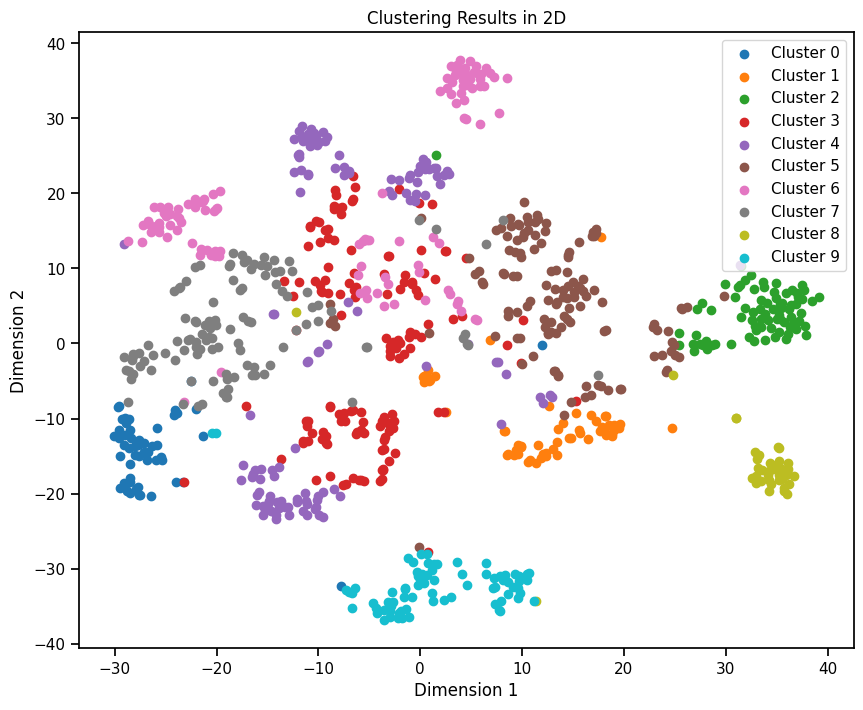

In [53]:
show_cluster_graph(mean_array, exp1_df['cluster_10'])

# Experiment 2: Utilizing KMCCA

In [7]:
import numpy as np
from mvlearn.embed import KMCCA
from mvlearn.model_selection import train_test_split
from mvlearn.plotting import crossviews_plot
import warnings
warnings.filterwarnings("ignore")

In [42]:
np.random.seed(1)
Xs = [item1_np, sp_long_np, orbis_np]
Xs_train, Xs_test = train_test_split(Xs, test_size=0.3, random_state=42)

kmcca = KMCCA(#kernel="poly", kernel_params={'degree': 2.0, 'coef0': 0.1},
              n_components=4, regs=0.01)
scores = kmcca.fit_transform(Xs_test)

# crossviews_plot(Xs, ax_ticks=False, ax_labels=True, equal_axes=True,
#                 title='Simulated data crossplot: linear setting')

# crossviews_plot(scores, ax_ticks=False, ax_labels=True, equal_axes=True,
#                 title='Scores crossplot: linear KMCCA')

# Now, we assess the canonical correlations achieved on the testing data

print(f'Test data canonical correlations: {kmcca.canon_corrs(scores)}')

Test data canonical correlations: [[[1.         0.95956673 0.92344635]
  [0.95956673 1.         0.93363075]
  [0.92344635 0.93363075 1.        ]]

 [[1.         0.94101292 0.87654199]
  [0.94101292 1.         0.88767326]
  [0.87654199 0.88767326 1.        ]]

 [[1.         0.90572975 0.83664873]
  [0.90572975 1.         0.89263684]
  [0.83664873 0.89263684 1.        ]]

 [[1.         0.81815654 0.81593348]
  [0.81815654 1.         0.79644686]
  [0.81593348 0.79644686 1.        ]]]


In [33]:
Xs_transformed = kmcca.transform(Xs)
print(Xs_transformed.shape)
Xs_transformed

(3, 926, 64)


array([[[ 0.01942114, -0.01512443, -0.00708654, ...,  0.03962057,
         -0.05203991,  0.01204564],
        [-0.03333805, -0.04956414, -0.00395727, ..., -0.04695106,
         -0.07791196,  0.08718288],
        [-0.02097078,  0.10214895,  0.03806294, ...,  0.06043824,
          0.09153933, -0.01061011],
        ...,
        [-0.03143817, -0.04442336, -0.01186916, ...,  0.01969703,
          0.06050433, -0.04944281],
        [-0.00758463,  0.02526037,  0.00010218, ..., -0.07798242,
          0.01983374, -0.01369057],
        [ 0.01993237,  0.04042144, -0.04947285, ..., -0.047914  ,
         -0.04717159, -0.02510294]],

       [[ 0.01296415, -0.01481236, -0.03062365, ..., -0.05188687,
         -0.00825696,  0.03091947],
        [-0.03875078, -0.04663553, -0.01196271, ..., -0.05904962,
         -0.03024961,  0.02283951],
        [-0.03105114,  0.09870569,  0.04396885, ...,  0.01618188,
         -0.01657919,  0.02253552],
        ...,
        [-0.0248286 , -0.04193686, -0.01380082, ..., -